In [3]:

%load_ext autoreload
from casadi import * 
import numpy as np
import matplotlib.pyplot as plt

from class_NMPC import NMPC
%matplotlib inline

<h1> Define problem parameters </h1>

In [4]:
%autoreload
Q = np.diag([120,   #x
            120,    #y
            120,    #z
            1e-2,   #phi
            1e-2,   #theta
            1,   #psi
            7e-1,   #vx
            1,      #vy
            4,      #vz
            1e-5,   #phi_dot
            1e-5,   #theta_dot
            10])   #psi_dot

R = np.diag([1, 1, 1, 1])* 0.06


<h1> Method 1 : Direct Multiple Shooting </h1>

In [5]:
#Define the DMS solver params
N_dms = 50 # number of control intervals to solve for
T_dms = 0.1 # time period in which to solve for the control intervals
Tf_dms = 15 # time period for the MPC to solve the problem
nlp_opt_dms = {'ipopt': {'print_level': 0, 'max_iter':1000}, 'print_time': 0}
method = "DMS"




Create solver instance and instantiate solve with the parameters


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



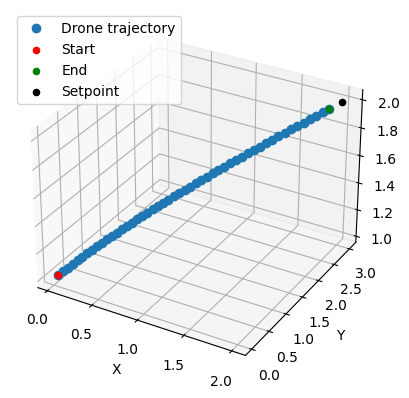

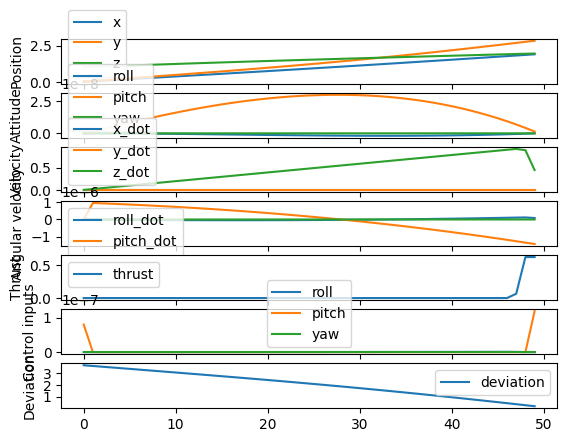

In [6]:
%autoreload
mpc = NMPC(Q, R, N_dms, T_dms, Tf_dms, nlpopts_dms=nlp_opt_dms)
x_init = [0,0,1]
x_desired =[2,3,2]
mpc.degree = None
mpc.method = method
mpc.solve_open_loop_and_plot(x_init, x_desired)

The above plot shows the solution of the solver, for a the current horizon length, from the start point to the desired endpoint. Here we see that the Final state has converged somewhat close to the final endpoint

<h1> Method 2 : Direct Collocation </h1>

In [7]:
# define the solver params
%autoreload
N_dc = 50 # number of control intervals to solve for
T_dc = 0.1 # time period in which to solve for the control intervals
Tf_dc = 15 # time period for the MPC to solve the problem
nlp_opt_dc = {'ipopt': {'print_level': 0, 'max_iter':1000}, 'print_time': 0}
method = "DC"
degree = 2



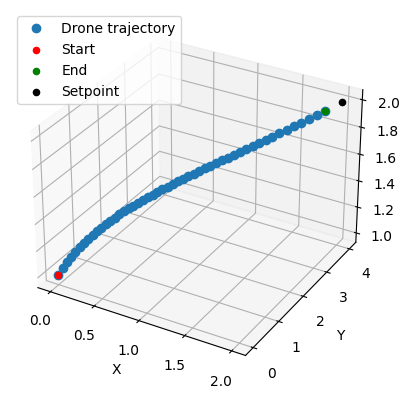

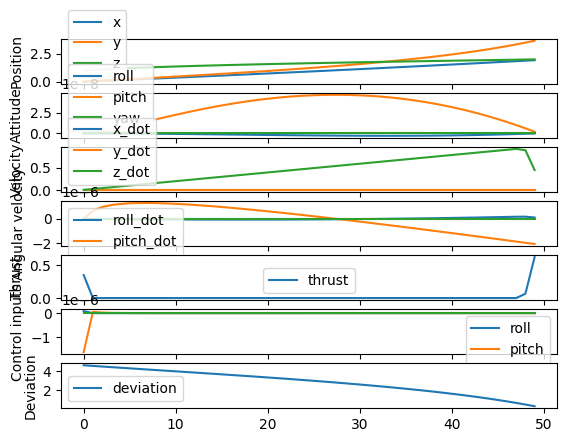

In [8]:
%autoreload
dc_mpc = NMPC(Q, R, N_dc, T_dc, Tf_dc, nlpopts_dc=nlp_opt_dc)
x_init = [0,0,1]
x_desired =[2,4,2]
dc_mpc.degree = degree
dc_mpc.method = method
dc_mpc.solve_open_loop_and_plot(x_init, x_desired)

In [9]:
[0]*mpc.nu

[0, 0, 0, 0]

<h1> Closed Loop MPC </h1>

<h4> Method 1 : Direct multiple Shooting </h4>

The result has been saved in test_dms.mp4

The system has reached the desired state in 66 steps
Final state: [ 1.99997770e+00  2.99983118e+00  6.99989827e+00 -3.45855853e-07
  1.49445895e-07  1.00745374e-06 -7.11363997e-07 -9.60476775e-07
  2.48505051e-02 -2.39386633e-04 -1.16968115e-04 -1.63644985e-04]


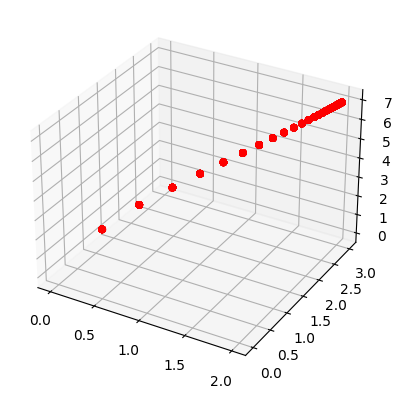

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline
%autoreload
#Define the DMS solver params
N_dms = 10 # number of control intervals to solve for
T_dms = 0.01 # time period in which to solve for the control intervals
Tf_dms = 15 # time period for the MPC to solve the problem
nlp_opt_dms = {'ipopt': {'print_level': 0, 'max_iter':50}, 'print_time': 0}
method = "DMS"
N_sim = 500
min_dev = 0.01
stable_state_counter = 0
#create plot to plot the positions in real time

xs = []
ys = []
zs = []


x_init = [0,0,1]
x_desired = [2,3,7]
mpc_dms = NMPC(Q, R, N_dms, T_dms, Tf_dms, None, nlpopts_dms=nlp_opt_dms)
mpc_dms.set_init_value(x_init)
mpc_dms.set_desired_value(x_desired)
mpc_dms.set_solver(method)
step = 0


while step < N_sim and stable_state_counter<30:
    mpc_dms.solve_for_next_state()
    mpc_dms.extract_next_state(step, False)
    # print(step)
    xs.append(mpc_dms.X_opt_current[0])
    ys.append(mpc_dms.X_opt_current[1])
    zs.append(mpc_dms.X_opt_current[2])
    # print("current pose: {}".format(mpc_dms.X_opt_current[:3]))
    
    step += 1
    if np.linalg.norm(mpc_dms.X_opt_current[:3] - mpc_dms.x_desired[:3]) < min_dev:
        stable_state_counter += 1
print("The system has reached the desired state in {} steps".format(step))
print('Final state: {}'.format(mpc_dms.X_opt_current))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  
def animate(i):
    ax.scatter(xs[:i], ys[:i], zs[:i], c='r', marker='o')
    return ax
    
ani = animation.FuncAnimation(fig, animate, frames=step, repeat = False)
ani.save('test_dms.mp4', fps=step/60, extra_args=['-vcodec', 'libx264'])



<h4> Method 2: Direct Collocation </h4>

The result has been saved in test_dc.mp4

0
current pose: [1.3924435  0.35788946 2.63483372]
1
current pose: [1.83051354 0.75843012 3.54662905]
2
current pose: [2.38892456 1.35824902 4.19854154]
3
current pose: [2.73824492 1.72747835 4.64333337]
4
current pose: [3.13064085 2.14292848 5.05877102]
5
current pose: [3.44647934 2.47347761 5.38592152]
6
current pose: [3.70274645 2.73813137 5.64848705]
7
current pose: [3.91247679 2.95172612 5.86255222]
8
current pose: [4.08638073 3.126434   6.03998219]
9
current pose: [4.23167052 3.2705665  6.18858425]
10
current pose: [4.35360964 3.39016096 6.31386352]
11
current pose: [4.4562607  3.48981753 6.41992943]
12
current pose: [4.54018057 3.57046445 6.50743351]
13
current pose: [4.61191875 3.6389518  6.58271288]
14
current pose: [4.67304016 3.69689766 6.64719419]
15
current pose: [4.72495783 3.74583541 6.70228152]
16
current pose: [4.76895524 3.78705014 6.74923332]
17
current pose: [4.80617288 3.82178377 6.78917163]
18
current pose: [4.83749599 3.850906   6.82292533]
19
current pose: [4.86

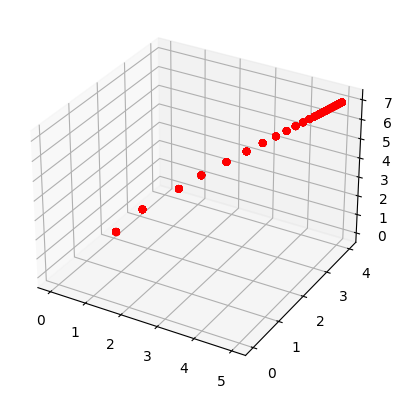

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline
%autoreload
#Define the DMS solver params
N_dc = 5 # number of control intervals to solve for
T_dc= 0.01 # time period in which to solve for the control intervals
Tf_dc = 15 # time period for the MPC to solve the problem
nlp_opt_dms = {'ipopt': {'print_level': 0, 'max_iter':50}, 'print_time': 0}
method = "DC"
degree = 2
N_sim = 500
min_dev = 0.01
stable_state_counter = 0
#create plot to plot the positions in real time

xs = []
ys = []
zs = []


x_init = [1,0,1]
x_desired = [5,4,7]
mpc_dc = NMPC(Q, R, N_dc, T_dc, Tf_dc, nlpopts_dc=nlp_opt_dc)
mpc_dc.set_init_value(x_init)
mpc_dc.set_desired_value(x_desired)
mpc_dc.set_solver(method, degree)
step = 0


while step < N_sim and stable_state_counter<30:
    mpc_dc.solve_for_next_state()
    mpc_dc.extract_next_state(step, False)
    print(step)
    xs.append(mpc_dc.X_opt_current[0])
    ys.append(mpc_dc.X_opt_current[1])
    zs.append(mpc_dc.X_opt_current[2])
    print("current pose: {}".format(mpc_dc.X_opt_current[:3]))
    
    step += 1
    if np.linalg.norm(mpc_dc.X_opt_current[:3] - mpc_dc.x_desired[:3]) < min_dev:
        stable_state_counter += 1
print("The system has reached the desired state in {} steps".format(step))
print('Final state: {}'.format(mpc_dc.X_opt_current))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  
def animate(i):
    ax.scatter(xs[:i], ys[:i], zs[:i], c='r', marker='o')
    return ax
    
ani = animation.FuncAnimation(fig, animate, frames=step, repeat = False)
ani.save('test_dc.mp4', fps=step/60, extra_args=['-vcodec', 'libx264'])

In [41]:
mpc_dc.

SyntaxError: invalid syntax (1982892114.py, line 1)